# NBA referees analysis: endgame accuracy

This notebook permorms an analysis of the accuracy of NBA referees with respect to whether a call is correct or not in the last 2 minutes of a game. This notebook was inspired by Austin Rochford's [NBA Foul Calls and Bayesian Item Response Theory](https://www.austinrochford.com/posts/2017-04-04-nba-irt.html). Our main aim is to quantify the uncertainty of a call being correct with respect to an experience of referees. This can be an important indicator for league managers. An indicator of variance could be particularly useful as the mean correct calls can be very similar for several referees, but at the same time a small variance is... Comment on game more delicate..

The analysis is carried out with three Bayesian models: 
- a vanilla unpooled beta-Bernoulli model,
- a hiherchical beta-Bernoulli model,
- a vanilla logit model
- a hiherchical logit model,
- a partially pooled logit model,
- a log-odds ratio with linear estimation of experience impact.

For the latter two the hierarchy is introduced by classifying referees with respect to three experience levels, namely less than 10 years, between 10 and 20 and more than 20 years of refereeing NBA games. 

The main conlclusion is that there is a significant difference in precision between referees with less than 10 years experience and more than 10 years experience.


## Research questions
- Which referees are more likely to make a correct call in the last two minutes of the game? 
- What is the impact of referee's experience in making a correct call?
- What is a good classification of experience to classify engame precision?

[Data set](https://github.com/polygraph-cool/last-two-minute-report) derived from the NBA's [Last Two Minute Report](http://official.nba.com/nba-last-two-minute-reports-archive/) by [Russell Goldenberg](http://russellgoldenberg.com/) of [The Pudding](https://pudding.cool/). NBA referee list can be found here: https://www.basketball-reference.com/referees/.

## Comments on data issues 
- Lack of data on the referee that made the call.
- Referees selection.
- Other variables that might be taken into account...
- Use a loss function with respect to th...
- Other approaches.
- Comment on model check.
- Assuming each referee calls/noncalls independently of other referees.

## Data collection and cleaning
We first import the data and remove calls from quarters before the 4th:

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import arviz as az
plt.style.use('seaborn')
%matplotlib inline

In [286]:
%%bash
DATA_URI=https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv
DATA_DEST=/tmp/all_games.csv

if [[ ! -e $DATA_DEST ]];
then
    wget -q -O $DATA_DEST $DATA_URI
fi

In [287]:
orig_df = pd.read_csv(
    '/tmp/all_games.csv',
    index_col='play_id',
    parse_dates=['date']
)

In [334]:
#orig_df.to_csv('file.csv')
USECOLS = [
    'period',
    'seconds_left',
    'call_type',   
    'review_decision',
    'away',
    'home',
    'ref_1',
    'date',
    'score_away',
    'score_home',
    'disadvantaged_team',
    'committing_team'
]
df = orig_df[USECOLS].dropna(axis=0)
df = df.loc[df.ref_1 != 'Violet Palmer']
df = df.loc[(df.period != 'Q1') & (df.period != 'Q2') & (df.period != 'Q3')]

We add four colunms: season,  the first referee id, referee experience (in years) and referee experience class as:
- 0: 0-10 years experience by 2021 (Junior)
- 1: 11-20 years experience by 2021 (Mid)
- 2: 21+ years experience by 2021 (Senior)

In [335]:
########################
#Add season column

def date_to_season(date):
    if date >= datetime.datetime(2017, 10, 17):
        return '2017-2018'
    elif date >= datetime.datetime(2016, 10, 25):
        return '2016-2017'
    elif date >= datetime.datetime(2015, 10, 27):
        return '2015-2016'
    else:
        return '2014-2015'
df = df.assign(season=lambda df: df['date'].apply(date_to_season))

########################
#Add referee ID

ref_lis = list(set(df.ref_1))
ref_lis.sort()
years_exp = []
for ref in ref_lis:
    ID = ref.split(' ')[1:][0][0:5] +ref[0:2]+'99r'
    #print(ID)
    try:
      df_re = pd.read_html(f'https://www.basketball-reference.com/referees/{ID.lower()}.html')
      #print(df_re)
      first, last = (df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[0,:][0],
                     df_re[0][[('Unnamed: 0_level_0', 'Season')]].iloc[-2,:][0])
      first, last = int(first[0:4]), int(last[0:4])
      #print(last-first)
      years_exp.append(last-first)
    except:
      print(f'Url not found for {ref}.')
      years_exp.append(None)        
def ref_exper(ref):
    idx = ref_lis.index(ref)
    return years_exp[idx]
df = df.assign(ref_exp=lambda df: df['ref_1'].apply(ref_exper))

########################
#Add referee experience (Junior = 10, Mid = 20, Senior = 30)

def exp_year_cls(ref_exp):
    try: 
       ref_exp = int(ref_exp) 
       if ref_exp >= 20:
        return 2
       elif ref_exp >= 10:
        return 1
       elif ref_exp >= 0:
        return 0   
    except:
        return None       
df = df.assign(ref_exp_cls=lambda df: df['ref_exp'].apply(exp_year_cls))

df = df.dropna()#loc[df.ref_exp_cls != None]

ref_lis = list(set(df.ref_1))
ref_lis.sort()

Url not found for J.T. Orr.


We now  plot all calls and non-calls. Then we
- remove non-calls from our data set, 
- number correct calls (CC) by 1 and incorrect calls (IC) by 0,
- index referees, and
- remove calls that happend with more than 120 seconds left on the period's clock.

CNC    8368
CC     4184
INC    1405
IC      165
Name: review_decision, dtype: int64

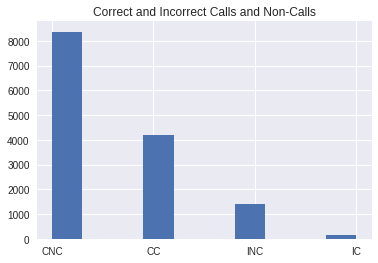

In [336]:
df['review_decision'].hist()
plt.title('Correct and Incorrect Calls and Non-Calls')
df['review_decision'].value_counts()

In [337]:
df_ref_c = df.loc[:,['seconds_left','review_decision','ref_1','ref_exp_cls','ref_exp']]
df_ref_c = df_ref_c.loc[(df_ref_c.review_decision == 'CC')|
                        (df_ref_c.review_decision == 'IC')].loc[df_ref_c.seconds_left<=120]

In [338]:
def call_to_binary(review_decision):
    out = 0
    if review_decision == 'CC':
        out = 1
    return out
df_ref_c = df_ref_c.assign(review_decision_bin=lambda df_ref_c:
                           df_ref_c['review_decision'].apply(call_to_binary))

In [339]:
ref_num = len(set(df_ref_c.ref_1))
ref_list = list(set(df_ref_c.ref_1))
ref_list.sort()
def ref_to_index(ref_1):
    return ref_list.index(ref_1)

df_ref_c = df_ref_c.assign(ref_1_idx=lambda df_ref_c: df_ref_c['ref_1'].apply(ref_to_index))

#remove referees with less than 50 calls.
#df_ref_c.ref_1.value_counts()
#df_ref_c.groupby('ref_1').filter(lambda x : len(x)>39).ref_1.value_counts()
df_ref_c = df_ref_c[df_ref_c.ref_exp_cls != None]
#set(df_ref_c.ref_exp_cls)


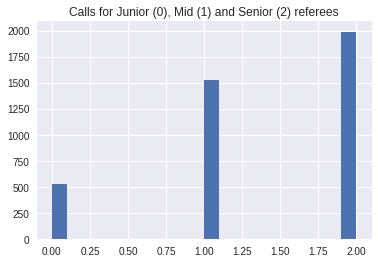

In [340]:
df_ref_c.ref_exp_cls.hist(bins=20)
plt.title('Calls for Junior (0), Mid (1) and Senior (2) referees');

Average correct calls among all calls: 96.47 %


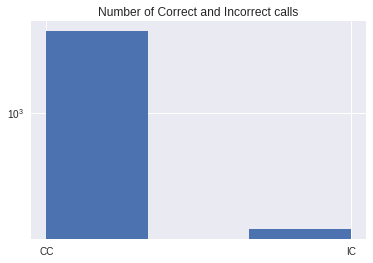

In [341]:
df_ref_c.review_decision.hist(bins=3,log=True)
plt.title('Number of Correct and Incorrect calls');
mu_cc = df_ref_c.review_decision_bin.value_counts()[1]/len(df_ref_c.review_decision_bin)
print('Average correct calls among all calls:', 100*round(mu_cc,4),'%')

In [376]:
ref_lis_exp = [ list(set(df_ref_c.loc[df_ref_c.ref_1 == x].ref_exp.values))[0] for x in ref_lis]
ref_lis_calls = [ len(df_ref_c.loc[df_ref_c.ref_1 == x]) for x in ref_lis]
ref_lis_ccalls = np.array([ len(df_ref_c.loc[(df_ref_c.ref_1 == x) &(
                   df_ref_c.review_decision_bin == 1)]) for x in ref_lis])/np.array(ref_lis_calls)
df_ref = pd.DataFrame({'Referee':ref_lis, 'Experience':ref_lis_exp,'Number of calls': ref_lis_calls,
                       '% of correct calls': 100*np.round(ref_lis_ccalls,3)});
df_ref.index.name = 'ID'
print('Expand the table below to see the full list of referees with the respective index.')
df_ref.head(51)

Expand the table below to see the full list of referees with the respective index.


Referee  Experience  Number of calls  % of correct calls
ID                                                                      
0          Bennie Adams        25.0              189                95.2
1          Bill Kennedy        25.0               49                98.0
2          Bill Spooner        31.0               12               100.0
3         Brent Barnaky        11.0              169                98.2
4          Brett Nansel         6.0                2               100.0
5           Brian Forte        13.0               95                96.8
6     Courtney Kirkland        21.0               31                93.5
7          Curtis Blair        12.0              119                95.8
8          Dan Crawford        28.0              141                96.5
9         David Guthrie        15.0               72                97.2
10          David Jones        26.0               45                97.8
11     Derek Richardson        25.0               18               100.0
12      Derrick Collins        21.0              177                93.2
13     Derrick Stafford        29.0               18                94.4
14            Ed Malloy        18.0               30               100.0
15              Eli Roe        10.0                3               100.0
16           Eric Dalen        12.0              112                96.4
17           Eric Lewis        16.0               78                97.4
18  Gediminas Petraitis         6.0               13               100.0
19         James Capers         4.0              152                98.7
20       Jason Phillips        23.0               13                92.3
21         Joe Crawford        27.0               34                97.1
22           John Goble        13.0               63                95.2
23           Josh Tiven        11.0               13                84.6
24      Kane Fitzgerald        11.0              111                97.3
25            Karl Lane        10.0               76                97.4
26            Ken Mauer        32.0               20                95.0
27         Kevin Cutler        11.0              116                96.6
28          Kevin Scott        10.0               11               100.0
29      Lauren Holtkamp         8.0               50                96.0
30     Leroy Richardson        25.0               22               100.0
31          Marat Kogut        11.0               47                95.7
32           Marc Davis        22.0              139                96.4
33          Mark Ayotte        25.0              151                98.7
34         Mark Lindsay        13.0               47                97.9
35          Matt Boland        21.0              130                95.4
36        Michael Smith        27.0               18                88.9
37        Mike Callahan        28.0              114                97.4
38       Mitchell Ervin         6.0               93                91.4
39      Monty McCutchen        24.0               52                98.1
40         Nick Buchert        11.0              164                98.2
41           Pat Fraher        25.0               79                96.2
42          Rodney Mott        25.0               18               100.0
43        Ron Garretson        30.0               55               100.0
44         Scott Foster        26.0              147                96.6
45          Sean Corbin        27.0              114                96.5
46       Steve Anderson         5.0              172                95.3
47        Tony Brothers        26.0              203                96.1
48           Tony Brown        18.0              147                95.9
49           Tre Maddox        10.0               55                92.7
50           Tyler Ford         6.0               48                97.9

## Beta-Bernoulli model
Denote by $n+1$ the number of plays with Foul calls,  $c$ the number of correct foul calls, by $R+1$ the number of referees. Indexing referees by $k=0,1,..,R$, we denote by $n_k$ the number of calls made made by referee $k$ and by $c_k$ the number of correct calls made by referee $k$. Let's study a simple Bernoulli trials model to estimate the probability $p_{k}$ where $k$ is a (leading) referee and $k(i)$ is the referee for the call $i$. The likelihood of (each realisation of) the model is
$$
y_i \sim p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]},
$$
and the prior on each $p_{k}$ is $Beta(\alpha,\beta)$ distributed, so that our model is
$$
p(\theta|y)\propto p(y|\theta)p(\theta) =\Big(\prod_{i=0}^n p_{k(i)}^{[i]}(1-p_{k(i)})^{[i]}\Big)\prod_{j=0}^R \binom{n_j}{c_j}\frac{p_{j}^{\alpha-1}(1-p_{j})^{\beta-1}}{B(\alpha, \beta)}.
$$

In [378]:
import pymc3 as pm
import arviz as az

In [379]:
ref_num = len(set(df.ref_1))
idx = df_ref_c.ref_1_idx
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern:
    #Prior
    p = pm.Beta('p', alpha =1,beta=1, shape=ref_num)    
    #Likelihood
    y = pm.Bernoulli('y',  p[idx], observed = observed_calls)
    

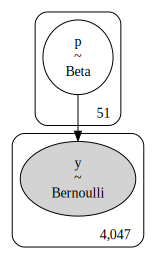

In [380]:
pm.model_to_graphviz(mod_bern)

In [381]:
n_tune = 1000
n_samples = 1000
seed = 2398572
chains =4
def sample(model, n_tune, n_samples, seed, chains):
    with model:
        full_trace = pm.sample(n_tune + n_samples, tune=n_tune, chains=chains, cores=chains, random_seed=seed, return_inferencedata=True, target_accept=.8)
        
    return full_trace#full_trace[n_tune:]

In [382]:
trace_bern = sample(mod_bern, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


By plotting the trace we can see quite different performances in making a correct call between different referees.

In [383]:
def energy_plot(trace):
    energy = trace.sample_stats.energy[0]
    energy_diff = np.diff(energy)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(energy - energy.mean(), bins=30,
            lw=0, alpha=0.5,
            label="Energy")
    ax.hist(energy_diff, bins=30,
            lw=0, alpha=0.5,
            label="Energy difference")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.legend()

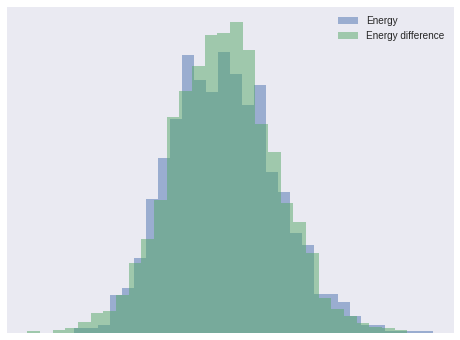

In [384]:
energy_plot(trace_bern)

/home/mas/anaconda3/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (51) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'p\n0'}>,
        <AxesSubplot:title={'center':'p\n1'}>,
        <AxesSubplot:title={'center':'p\n2'}>,
        <AxesSubplot:title={'center':'p\n3'}>],
       [<AxesSubplot:title={'center':'p\n4'}>,
        <AxesSubplot:title={'center':'p\n5'}>,
        <AxesSubplot:title={'center':'p\n6'}>,
        <AxesSubplot:title={'center':'p\n7'}>],
       [<AxesSubplot:title={'center':'p\n8'}>,
        <AxesSubplot:title={'center':'p\n9'}>,
        <AxesSubplot:title={'center':'p\n10'}>,
        <AxesSubplot:title={'center':'p\n11'}>],
       [<AxesSubplot:title={'center':'p\n12'}>,
        <AxesSubplot:title={'center':'p\n13'}>,
        <AxesSubplot:title={'center':'p\n14'}>,
        <AxesSubplot:title={'center':'p\n15'}>],
       [<AxesSubplot:title={'center':'p\n16'}>,
        <AxesSubplot:title={'center':'p\n17'}>,
        <AxesSubplot:title={'center':'p\n18'}>,
        <AxesSubplot:title={'center':'p\n19'}>],
       [<AxesSubplot:title={'center':'p\n20'}

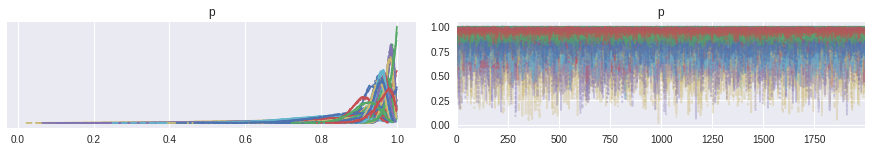

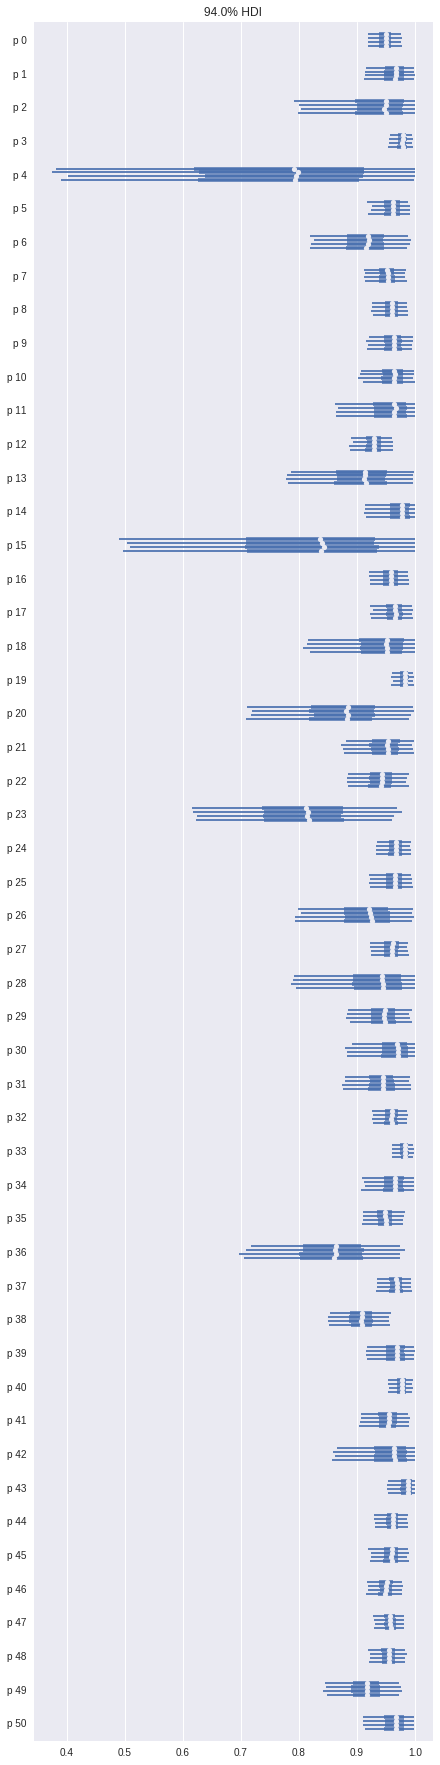

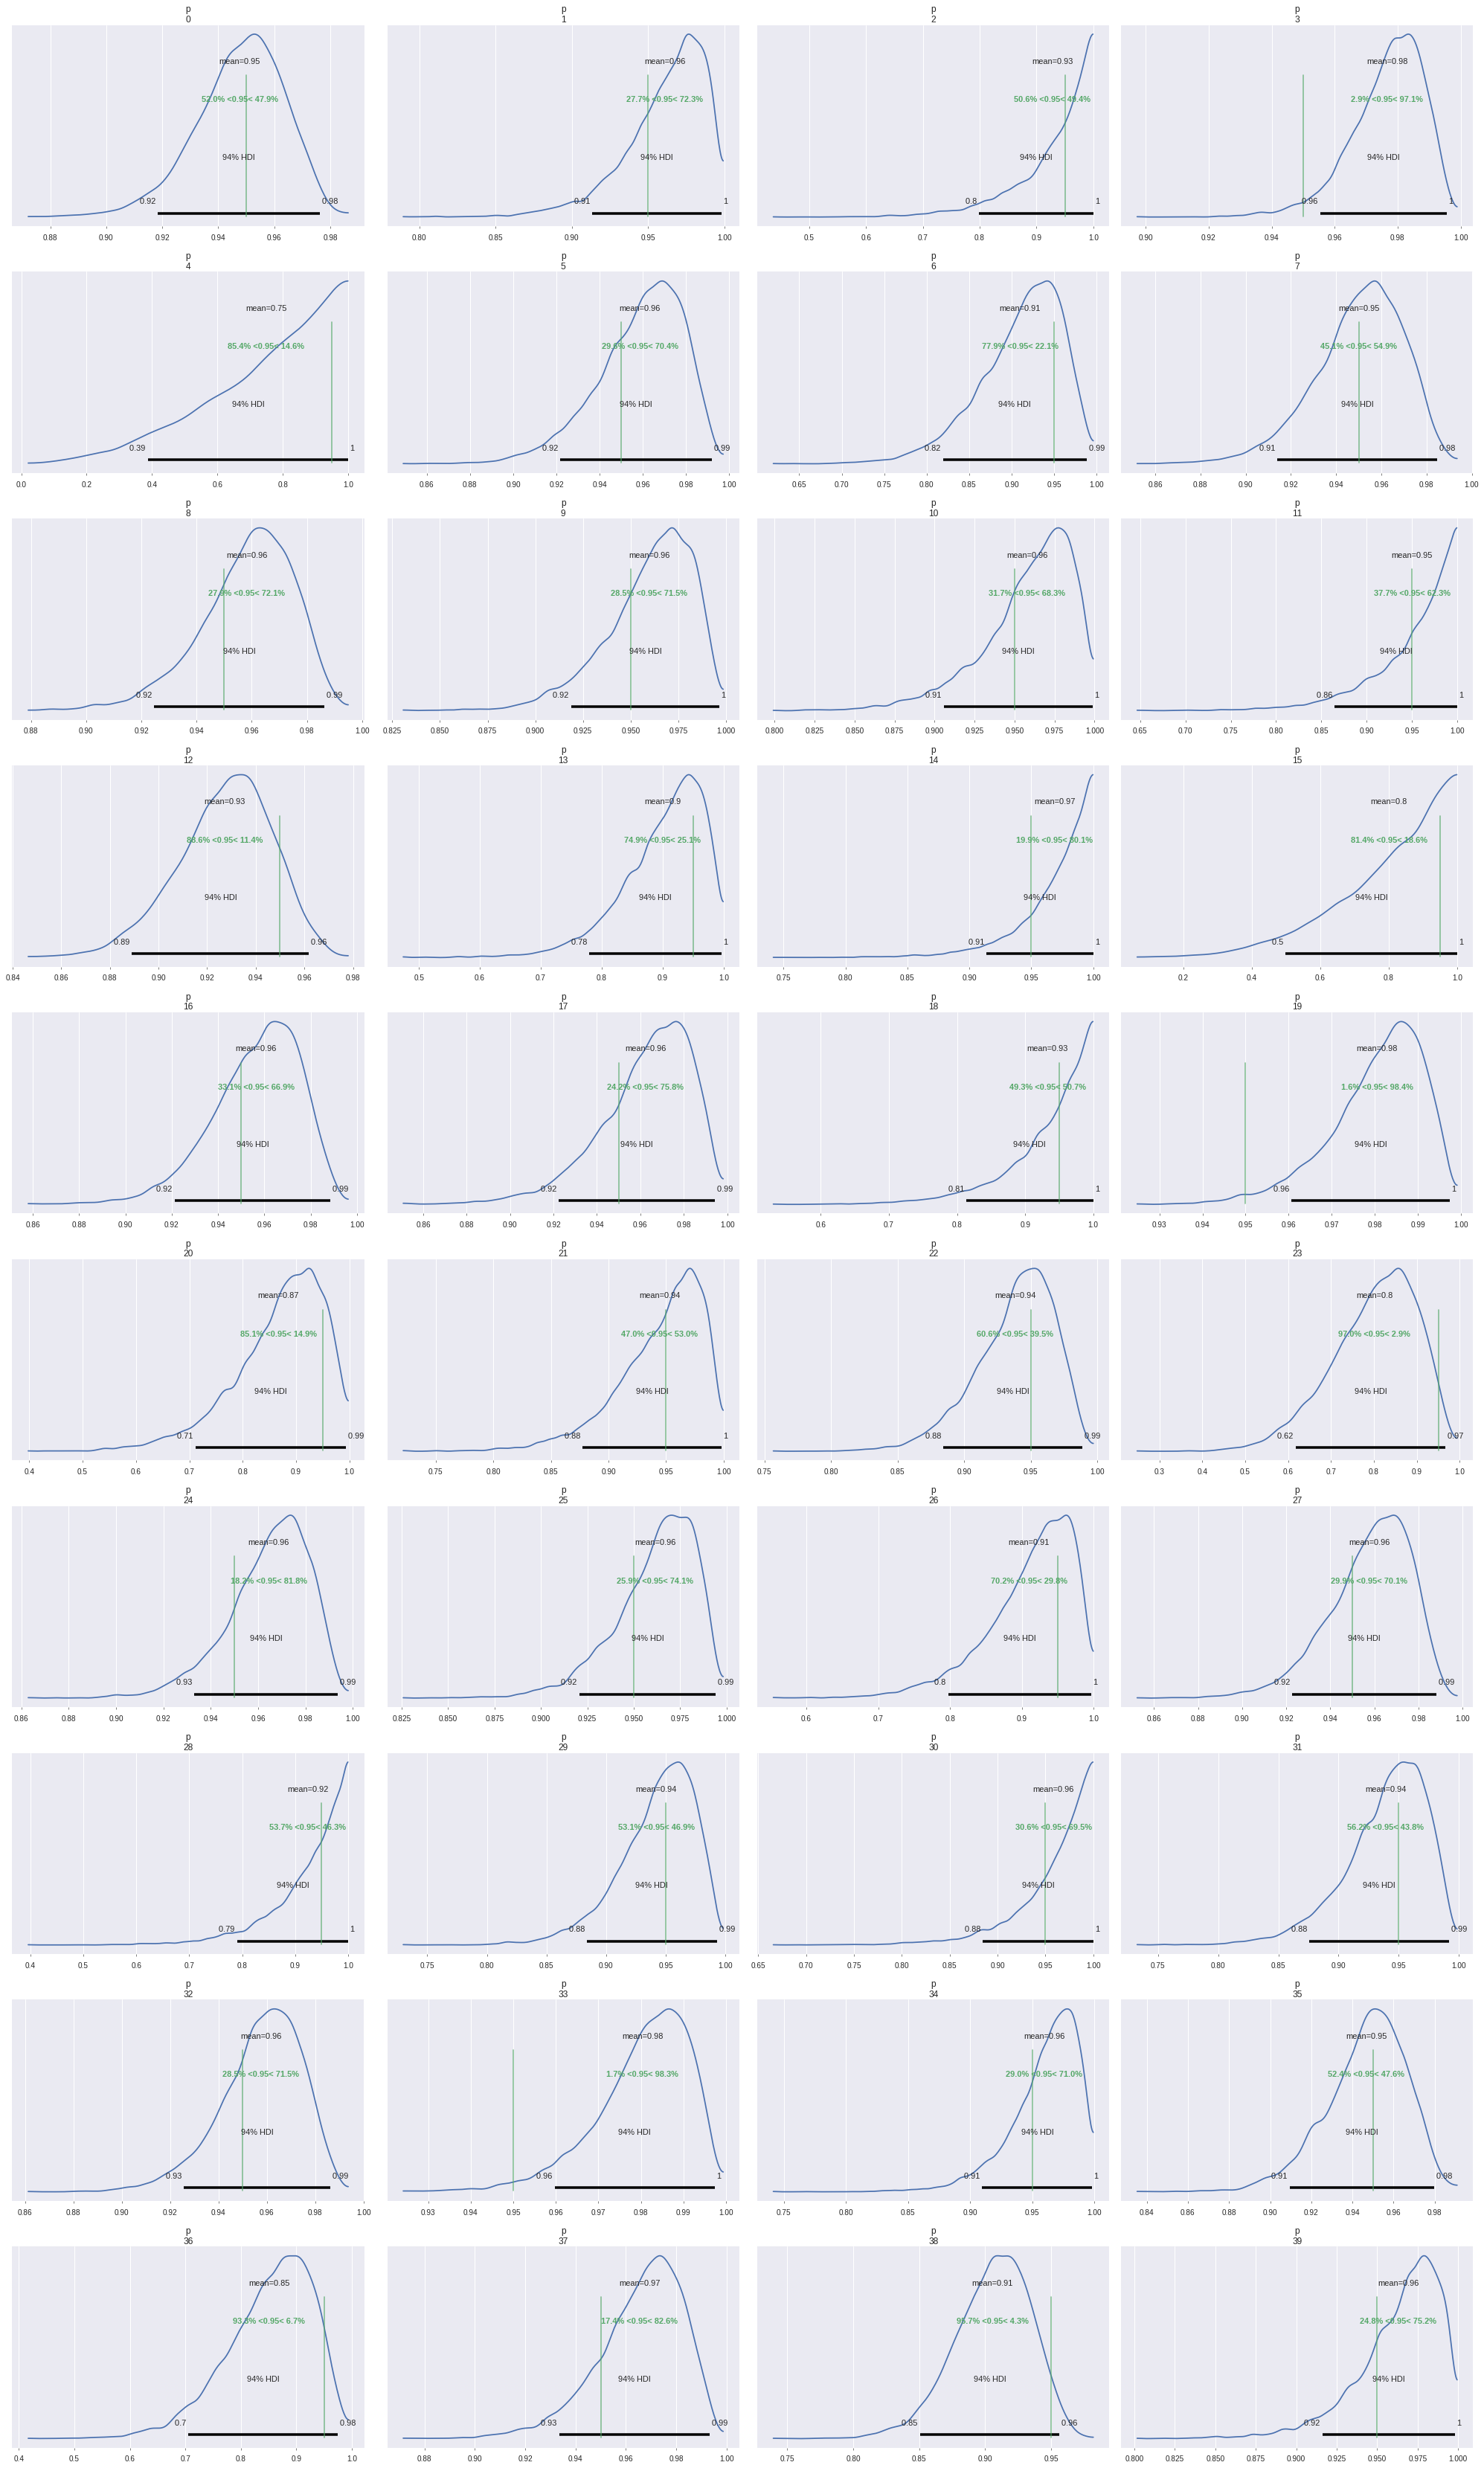

In [385]:
az.plot_trace(trace_bern) 
az.plot_forest(trace_bern) #ref_val = .9
az.plot_posterior(trace_bern, ref_val=.95 )#ax=ax[k, l]
    

In [386]:
trace_bern

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [387]:
with mod_bern:
    prior_checks = pm.sample_prior_predictive(samples=1000)
    ppc = pm.sample_posterior_predictive(trace_bern, samples=500)


/home/mas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


## Hierarchical beta-Bernoulli

In [388]:
idx = df_ref_c.ref_1_idx
idx_al_be = []
for j in range(len(set(idx))):
    try:
     idx_al_be.append(int(list(set(df_ref_c.ref_exp_cls.loc[df_ref_c.ref_1_idx == j].values))[0]/10))
    except:
        print(j)
        pass
observed_calls = df_ref_c.review_decision_bin

with pm.Model() as mod_bern_hier:
    #Hyperprior
    alpha = pm.Uniform('alpha', lower=0, upper=20, shape =3)
    beta = pm.Uniform('beta', lower=0, upper=20, shape =3)
    #Prior
    p = pm.Beta('p', alpha=alpha[idx_al_be], beta=beta[idx_al_be], shape=len(set(idx)))
    #Likelihood
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

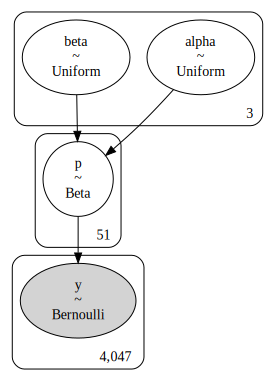

In [389]:
pm.model_to_graphviz(mod_bern_hier)

In [390]:
trace_bern_hier = sample(mod_bern_hier, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


In [391]:
trace_bern_hier

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

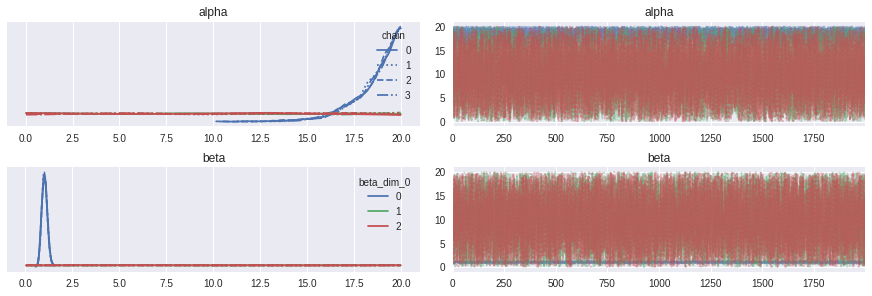

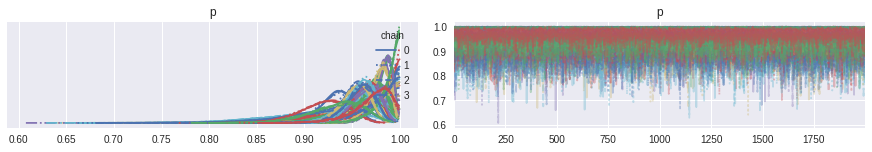

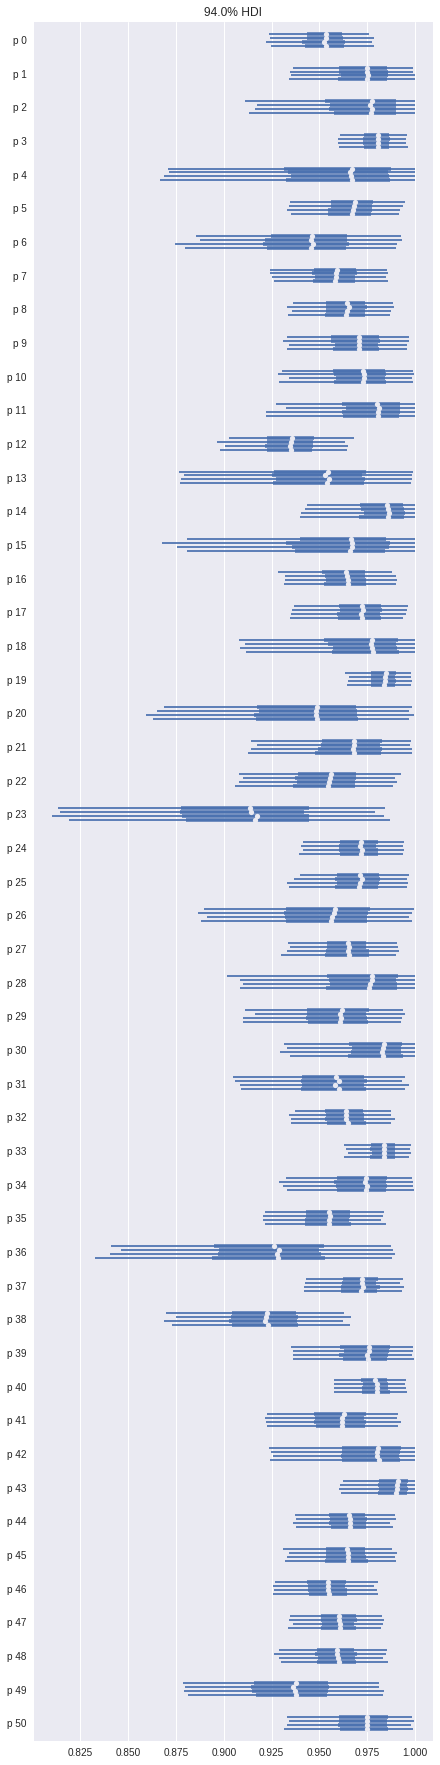

In [392]:
az.plot_trace(trace_bern_hier.posterior[['alpha','beta']], legend=True) 
az.plot_trace(trace_bern_hier.posterior['p'],legend=True) 
az.plot_forest(trace_bern_hier.posterior['p']) 

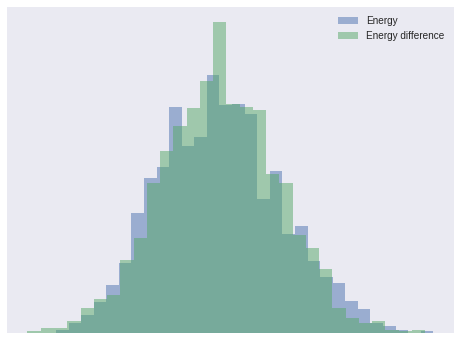

In [393]:
energy_plot(trace_bern_hier)

In [394]:
trace_bern_hier.posterior[['alpha','beta']]

<xarray.Dataset>
Dimensions:      (alpha_dim_0: 3, beta_dim_0: 3, chain: 4, draw: 2000)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * alpha_dim_0  (alpha_dim_0) int64 0 1 2
  * beta_dim_0   (beta_dim_0) int64 0 1 2
Data variables:
    alpha        (chain, draw, alpha_dim_0) float64 19.4 3.376 ... 3.255 17.83
    beta         (chain, draw, beta_dim_0) float64 0.8373 7.743 ... 19.63 12.02
Attributes:
    created_at:                 2021-05-27T13:52:52.437465
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.10.0
    sampling_time:              17.0006046295166
    tuning_steps:               1000

Recall that the averate of a beta stable distribution is $\alpha/(\alpha+\beta)$ and the variance is $\alpha\beta/((\alpha+\beta)^2(\alpha+\beta+1))$. So we sample from the the posterior distribution of $\alpha$ and $\beta$ to estimate the mean and variance with the formulae above.


In [395]:
with mod_bern_hier:
    prior_checks_bern_hier = pm.sample_prior_predictive(samples=1000)
    #ppc_bern_hier = pm.sample_posterior_predictive(trace_bern_hier, samples=500, random_seed=seed)
    ppc_bern_hier_alp = pm.sample_posterior_predictive(trace_bern_hier, var_names=['alpha'], samples=500, random_seed=seed)
    ppc_bern_hier_beta = pm.sample_posterior_predictive(trace_bern_hier, var_names=['beta'], samples=500, random_seed=seed)


/home/mas/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [396]:
means, var = [], []
for i in range(len(ppc_bern_hier_alp['alpha'][0,:])):
    m = ppc_bern_hier_alp['alpha'][:,i]/(ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i])
    v = (ppc_bern_hier_alp['alpha'][:,i]*ppc_bern_hier_beta['beta'][:,i])/(((ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i])**2)*(ppc_bern_hier_alp['alpha'][:,i]+ppc_bern_hier_beta['beta'][:,i] +1))
    means.append(m.mean())
    var.append(v.mean())

In [397]:
print('Under hierarchical beta-Bernoulli model:')
print('Means of Junior, Mid and Seniors:',means)
print('Stds of Junior, Mid and Seniors:',var)

Under hierarchical beta-Bernoulli model:
Means of Junior, Mid and Seniors: [0.9484994639619106, 0.49991911245950543, 0.4926725010798631]
Stds of Junior, Mid and Seniors: [0.0023901070707128607, 0.010859864506156943, 0.010685349418793915]


Note that the variance of the beta distribution for:
- a Senior referee is 27% higher than a Junior referee. 
- a Mid referee is 42% higher than a Junor referee.
- a Mid referee is 12% higher than a Senior referee.

Meanwhile the means are negligibly close but too low with respect to the global mean which is above 96%.

## Hierarchical Normal logit
We now assume that the log-odds-ratio of $p_k$ is normal distributed as $\eta_k $. First we partially pool the referees in our three experience chategories. This model can then be written as to 
$$
p_k = \text{sigmoid}(\eta_k)=\frac{1}{1+e^{-\eta_k}}\quad \text{with}\quad\eta_k\sim N(\mu_{j(k)},\sigma_{j(k)}), 
$$
where $j(k)\in\{0,1,2\}$ according to the experience of the referee $k$ (0 for Junior, 1 for Mid and 2 for Senior).

In [398]:
import theano.tensor as tt
with pm.Model() as log_norm_hier:
    eta = pm.Normal('eta', mu= 1,sigma=1 ,shape=3)
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta[idx_al_be])) 
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

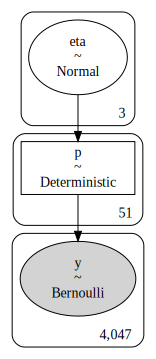

In [399]:
pm.model_to_graphviz(log_norm_hier)

In [400]:
trace_log_norm_hier = sample(log_norm_hier, n_tune, n_samples, seed, chains) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


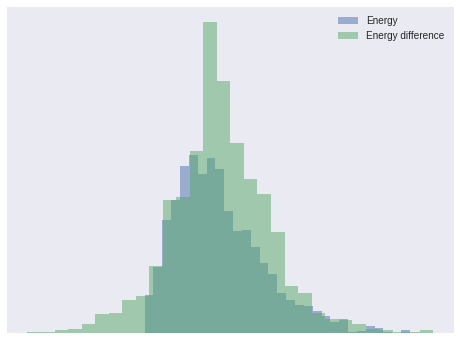

In [401]:
energy_plot(trace_log_norm_hier)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

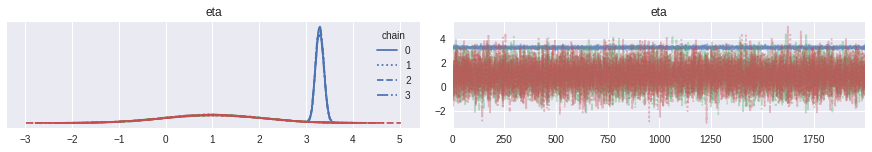

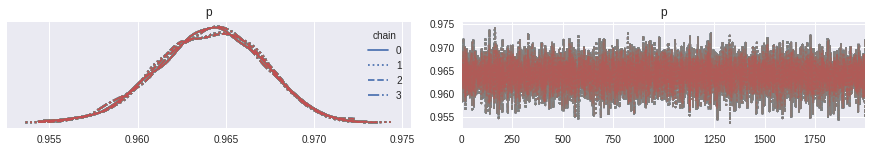

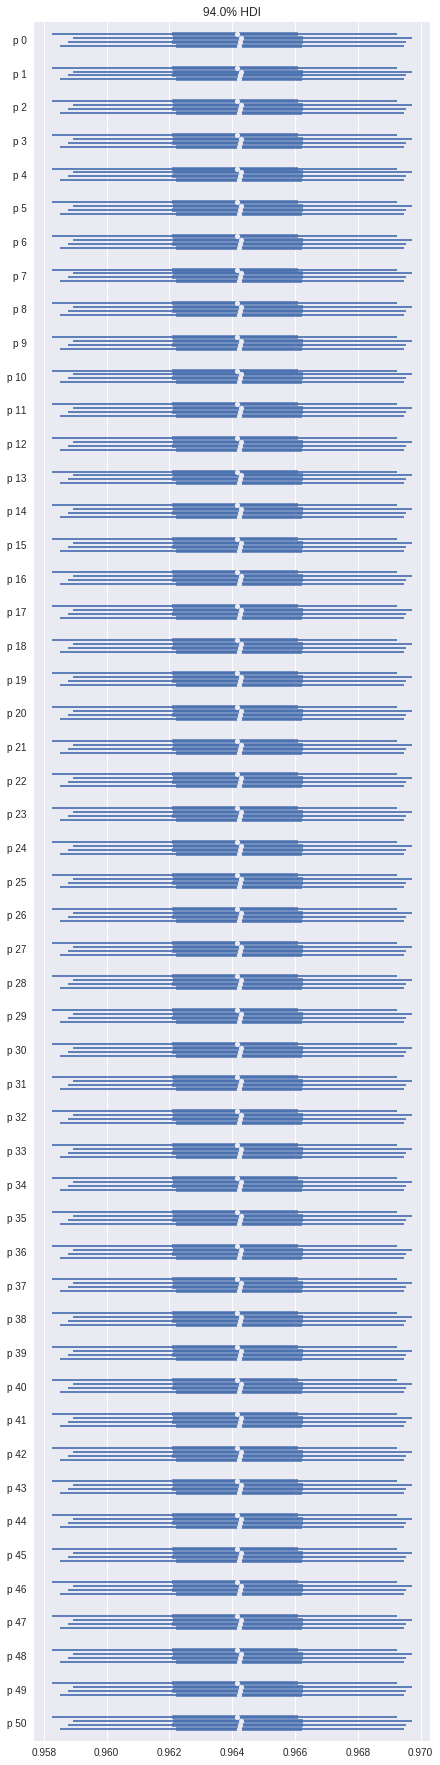

In [402]:
az.plot_trace(trace_log_norm_hier.posterior[['eta']], legend=True)
az.plot_trace(trace_log_norm_hier.posterior['p'],legend=True) 
az.plot_forest(trace_log_norm_hier.posterior['p']) 

/home/mas/anaconda3/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (51) in plot_posterior, generating only 40 plots
  warnings.warn(


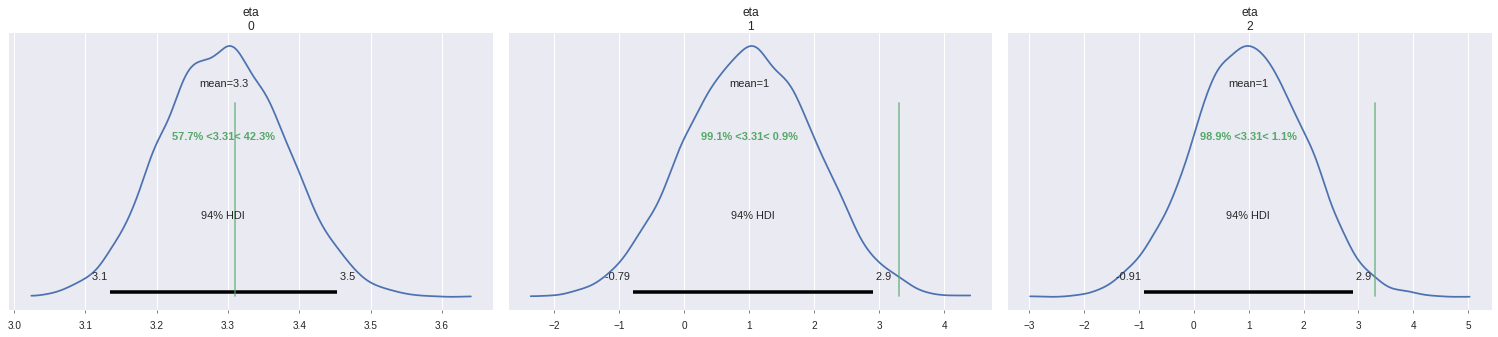

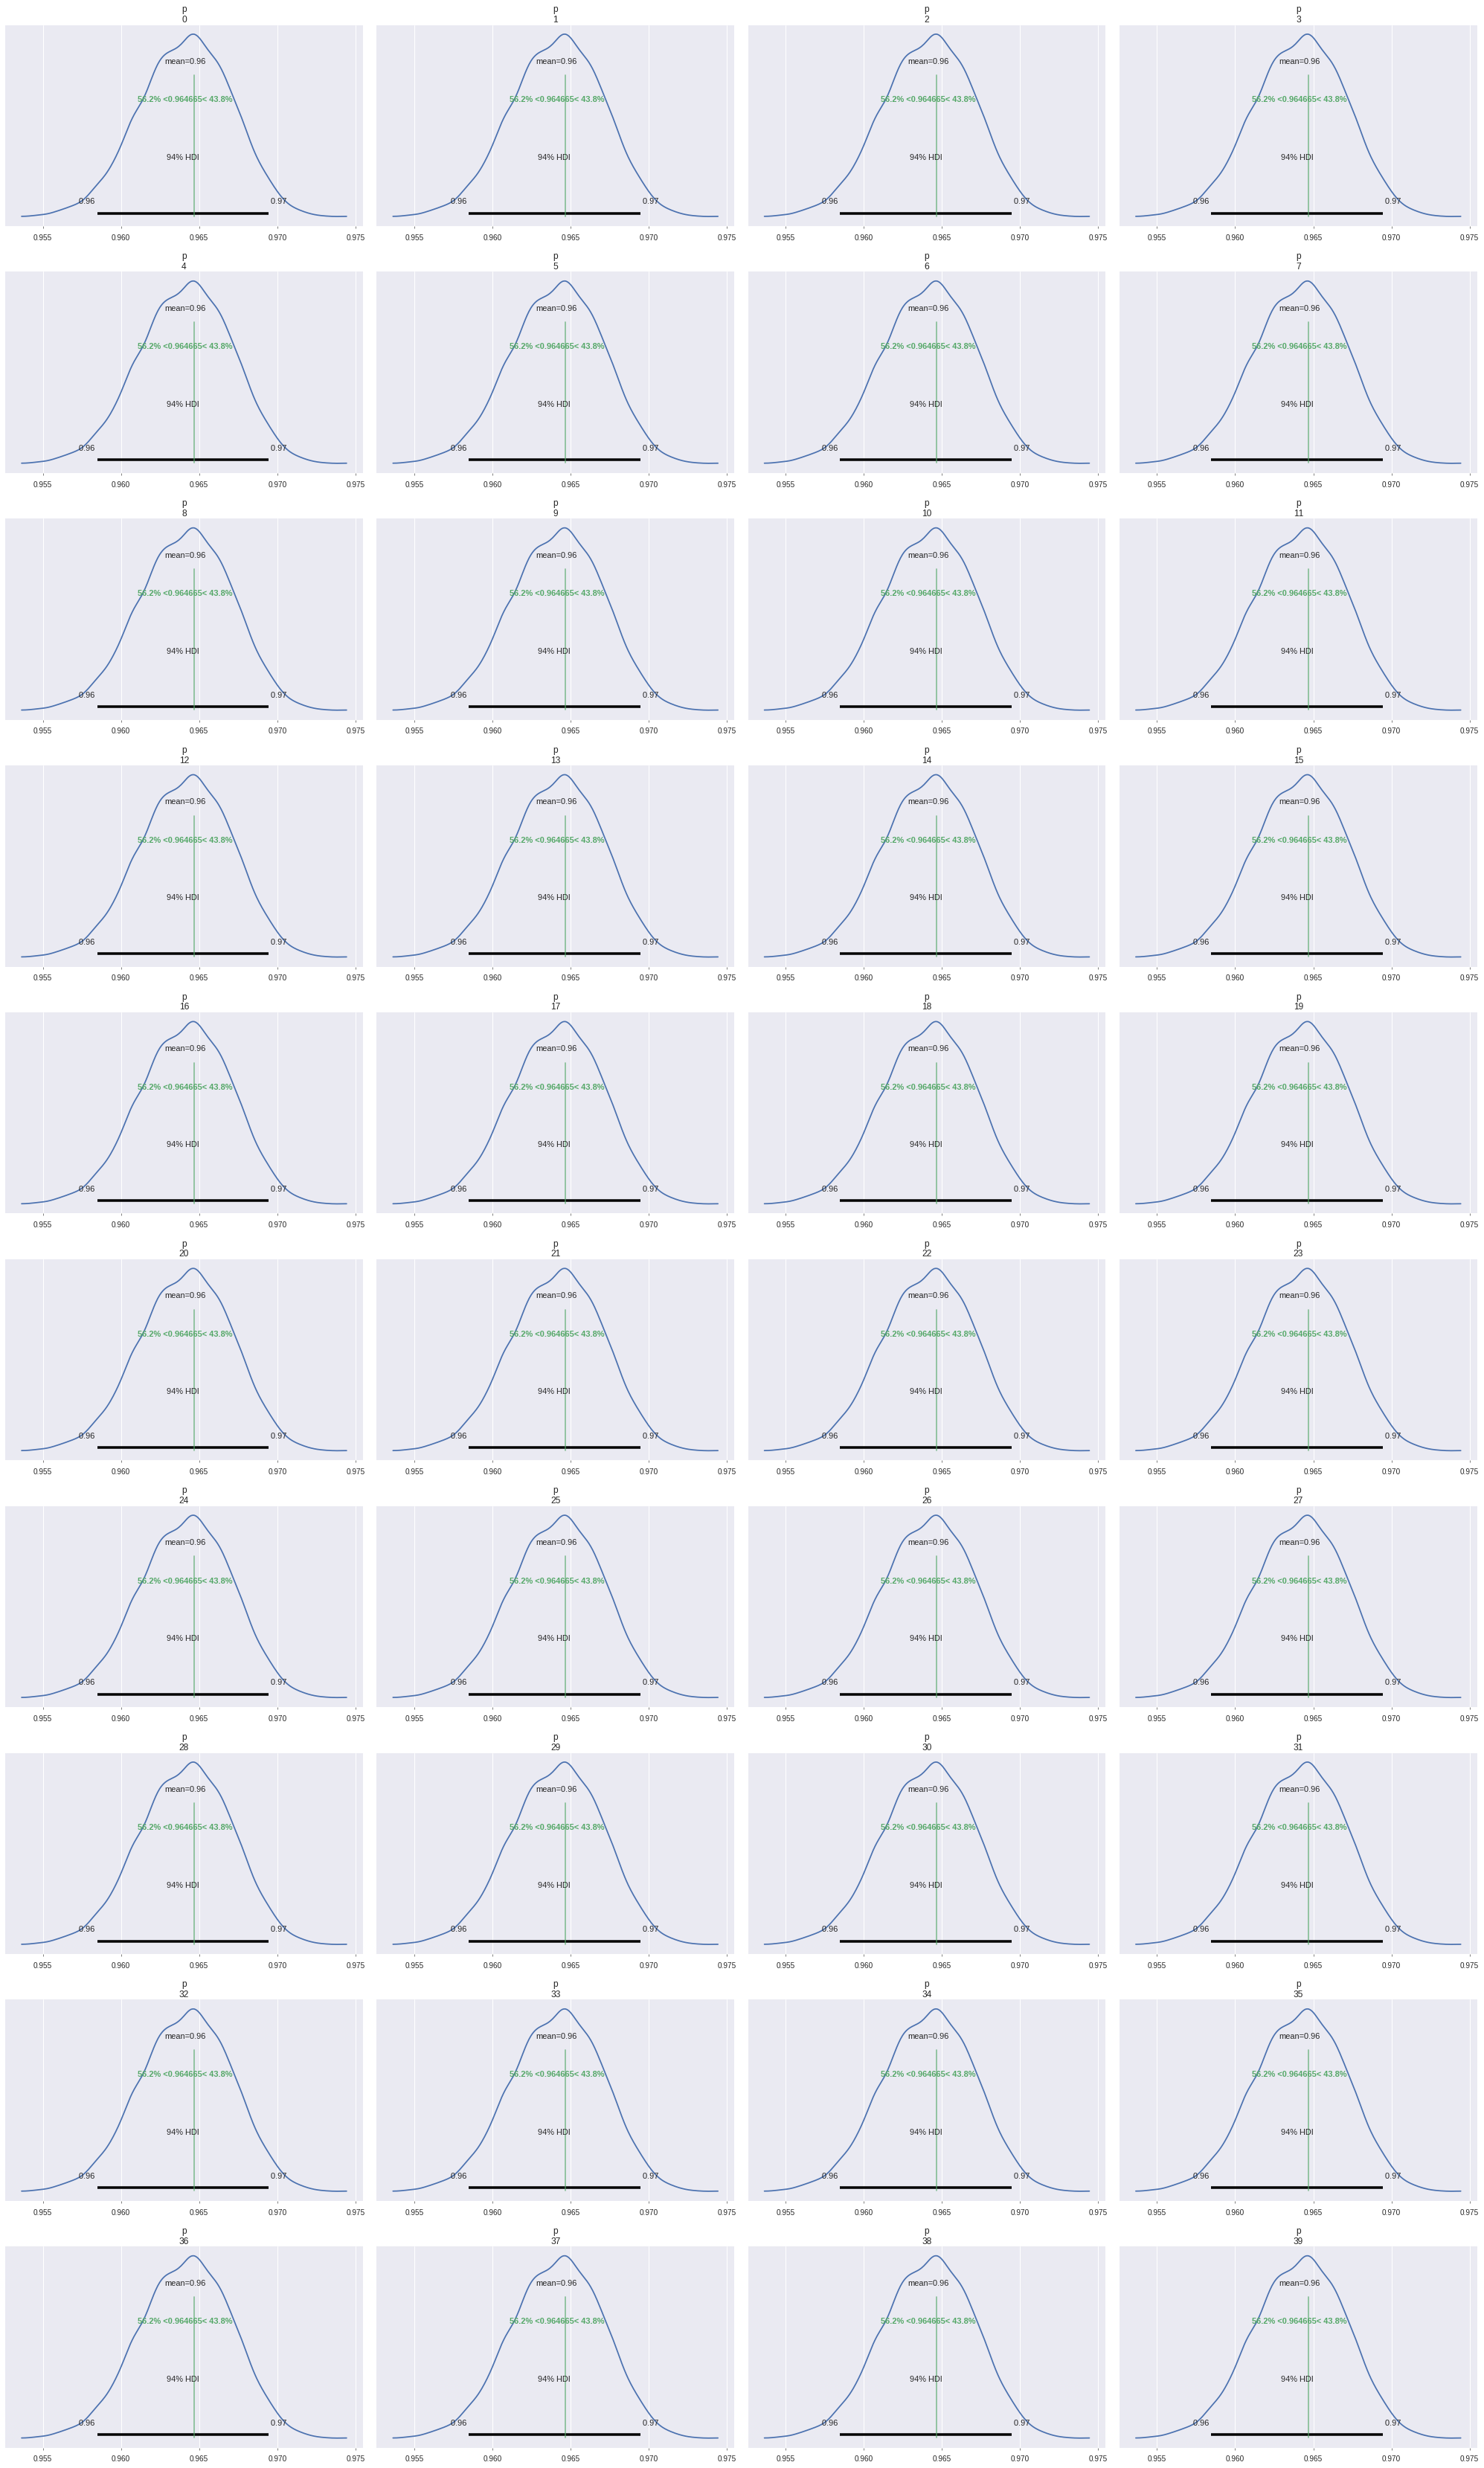

In [403]:
#plt.tight_layout()
pm.plot_posterior(trace_log_norm_hier, ['eta'], ref_val = round(np.log(mu_cc/(1-mu_cc)),2))
#pm.plot_posterior(trace_log_norm_hier, ['sigma'])
ax = pm.plot_posterior(trace_log_norm_hier, ['p'], ref_val = mu_cc);

### Posterior checks
We generate posterior predictive on behaviour of J,M,S etc and compare to previous one.


In [404]:
with log_norm_hier:
    ppc_log_norm_hier_eta = (pm.sample_posterior_predictive(trace_log_norm_hier, var_names=['eta'],
                                                           samples=chains*(4000+n_samples), random_seed=seed))

In [405]:
means, var = [], []
for i in range(len(ppc_log_norm_hier_eta['eta'][0,:])):
    p_ = 1/(1+np.exp(-ppc_log_norm_hier_eta['eta'][:,i]))
    means.append(p_.mean())
    var.append(p_.std())

In [406]:
print('Under hierarchical logit model:')
print('Means of Junior, Mid and Seniors:',means)
print('Stds of Junior, Mid and Seniors:',var)

Under hierarchical logit model:
Means of Junior, Mid and Seniors: [0.9641098397566786, 0.6976328433168868, 0.6947077392994947]
Stds of Junior, Mid and Seniors: [0.0029526759950713947, 0.18154672343761524, 0.1865527868243386]


Note that the variance of making a correct call for:
- a Junior referee is 82% higher than a Mid referee. 
- a Junion referee is 100% higher than a Senior referee.
- a Mid referee is 11% higher than a Senior referee.

Meanwhile the means are negligibly close but too low with respect to the global mean which is above 96%.

0.960377358490566 0.9679319371727748 0.963298139768728
(530,) (1528,) (1989,)


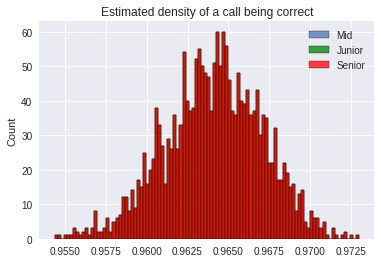

In [408]:
print(df_ref_c.loc[df_ref_c.ref_exp_cls == 0].review_decision_bin.value_counts(1)[1],
      df_ref_c.loc[df_ref_c.ref_exp_cls == 1].review_decision_bin.value_counts(1)[1],
      df_ref_c.loc[df_ref_c.ref_exp_cls == 2].review_decision_bin.value_counts(1)[1]) 
print(df_ref_c.loc[df_ref_c.ref_exp_cls == 0].review_decision_bin.shape,
      df_ref_c.loc[df_ref_c.ref_exp_cls == 1].review_decision_bin.shape,
      df_ref_c.loc[df_ref_c.ref_exp_cls == 2].review_decision_bin.shape)
#pm.plot_trace(trace_log_norm_hier)
'''
fig, ax = plt.subplots(1,1)
ax.hist(trace_log_norm_hier.posterior['p'][0,:,20],bins=100)
ax.hist(trace_log_norm_hier.posterior['p'][0,:,3],bins=100)
ax.hist(trace_log_norm_hier.posterior['p'][0,:,0],bins=100)
plt.show()
'''


#sns.kdeplot(trace_log_norm_hier.posterior['p'][0,:,3] , bw_method = 1 , fill = True)
fig,ax = plt.subplots()
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,3], ax =ax,bins=100, label='Mid')
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,20], ax =ax, color ='green',bins=100, label='Junior')
sns.histplot(trace_log_norm_hier.posterior['p'][0,:,0], ax =ax, color ='red', bins=100, label='Senior')
ax.set_title('Estimated density of a call being correct')
ax.legend()
plt.show()
#sns.kdeplot(trace_log_norm_hier.posterior['p'][0,:,0],  color ='red')
#set(df_ref_c.loc[df_ref_c.ref_exp_cls == 2].ref_1_idx)

## Age selection logit model
$$
p_k = \text{sigmoid}(-\eta_k)=\frac{1}{1+e^{-\eta_k}}.
$$
Version 2: 
$$
\eta_k\sim N(\mu_k,\sigma_k) +b_0+b_1x_k, \quad\text{with hyperpriors}\quad \mu_k\sim N(0,1),\,\sigma_k\sim \text{HalfCauchy}(1), \,b_0\sim N(0,1),\,b_1\sim N(0,1),
$$
where $X_k$ is the years of experience of a referee.


So the estimated slope $b_1$ is supposed to tell us...

In [409]:
'''

def seconds_left_to_mins(seconds_left):
    if seconds_left >= 100:
        return 100
    elif seconds_left >= 80:
        return 80
    elif seconds_left >= 60:
        return 60
    elif seconds_left >= 40:
        return 40
    elif seconds_left >= 20:
        return 20
    else:
        return 0
df = df.assign(time_left=lambda df: df['seconds_left'].apply(seconds_left_to_mins))

##########################
'''

"\n\ndef seconds_left_to_mins(seconds_left):\n    if seconds_left >= 100:\n        return 100\n    elif seconds_left >= 80:\n        return 80\n    elif seconds_left >= 60:\n        return 60\n    elif seconds_left >= 40:\n        return 40\n    elif seconds_left >= 20:\n        return 20\n    else:\n        return 0\ndf = df.assign(time_left=lambda df: df['seconds_left'].apply(seconds_left_to_mins))\n\n##########################\n"

Check comments on logit

Collcet highest to lowest variance and check referees
estimate how much variance is dependent on low sample size

In [410]:
set(df.season.values)

{'2014-2015', '2015-2016', '2016-2017'}

## Logit
Unpooled

In [411]:
with pm.Model() as log_norm:
    eta = pm.Normal('eta', mu= 1,sigma=1 ,shape=len(idx_al_be))
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta)) #
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

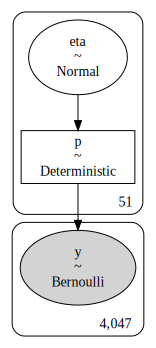

In [412]:
pm.model_to_graphviz(log_norm)

In [413]:
trace_log_norm = sample(log_norm, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


array([[<AxesSubplot:title={'center':'eta'}>,
        <AxesSubplot:title={'center':'eta'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

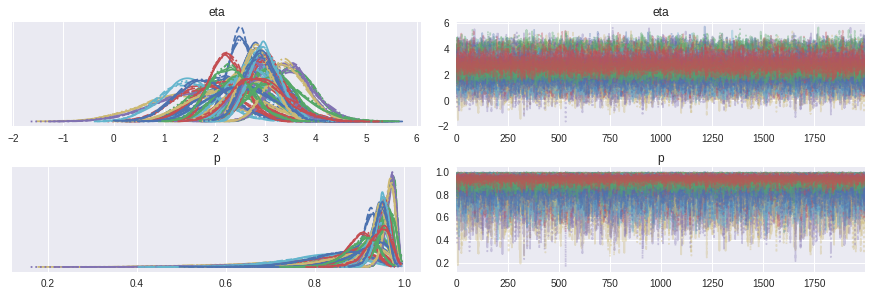

In [414]:
pm.plot_trace(trace_log_norm)

/home/mas/anaconda3/lib/python3.8/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (51) in plot_posterior, generating only 40 plots
  warnings.warn(


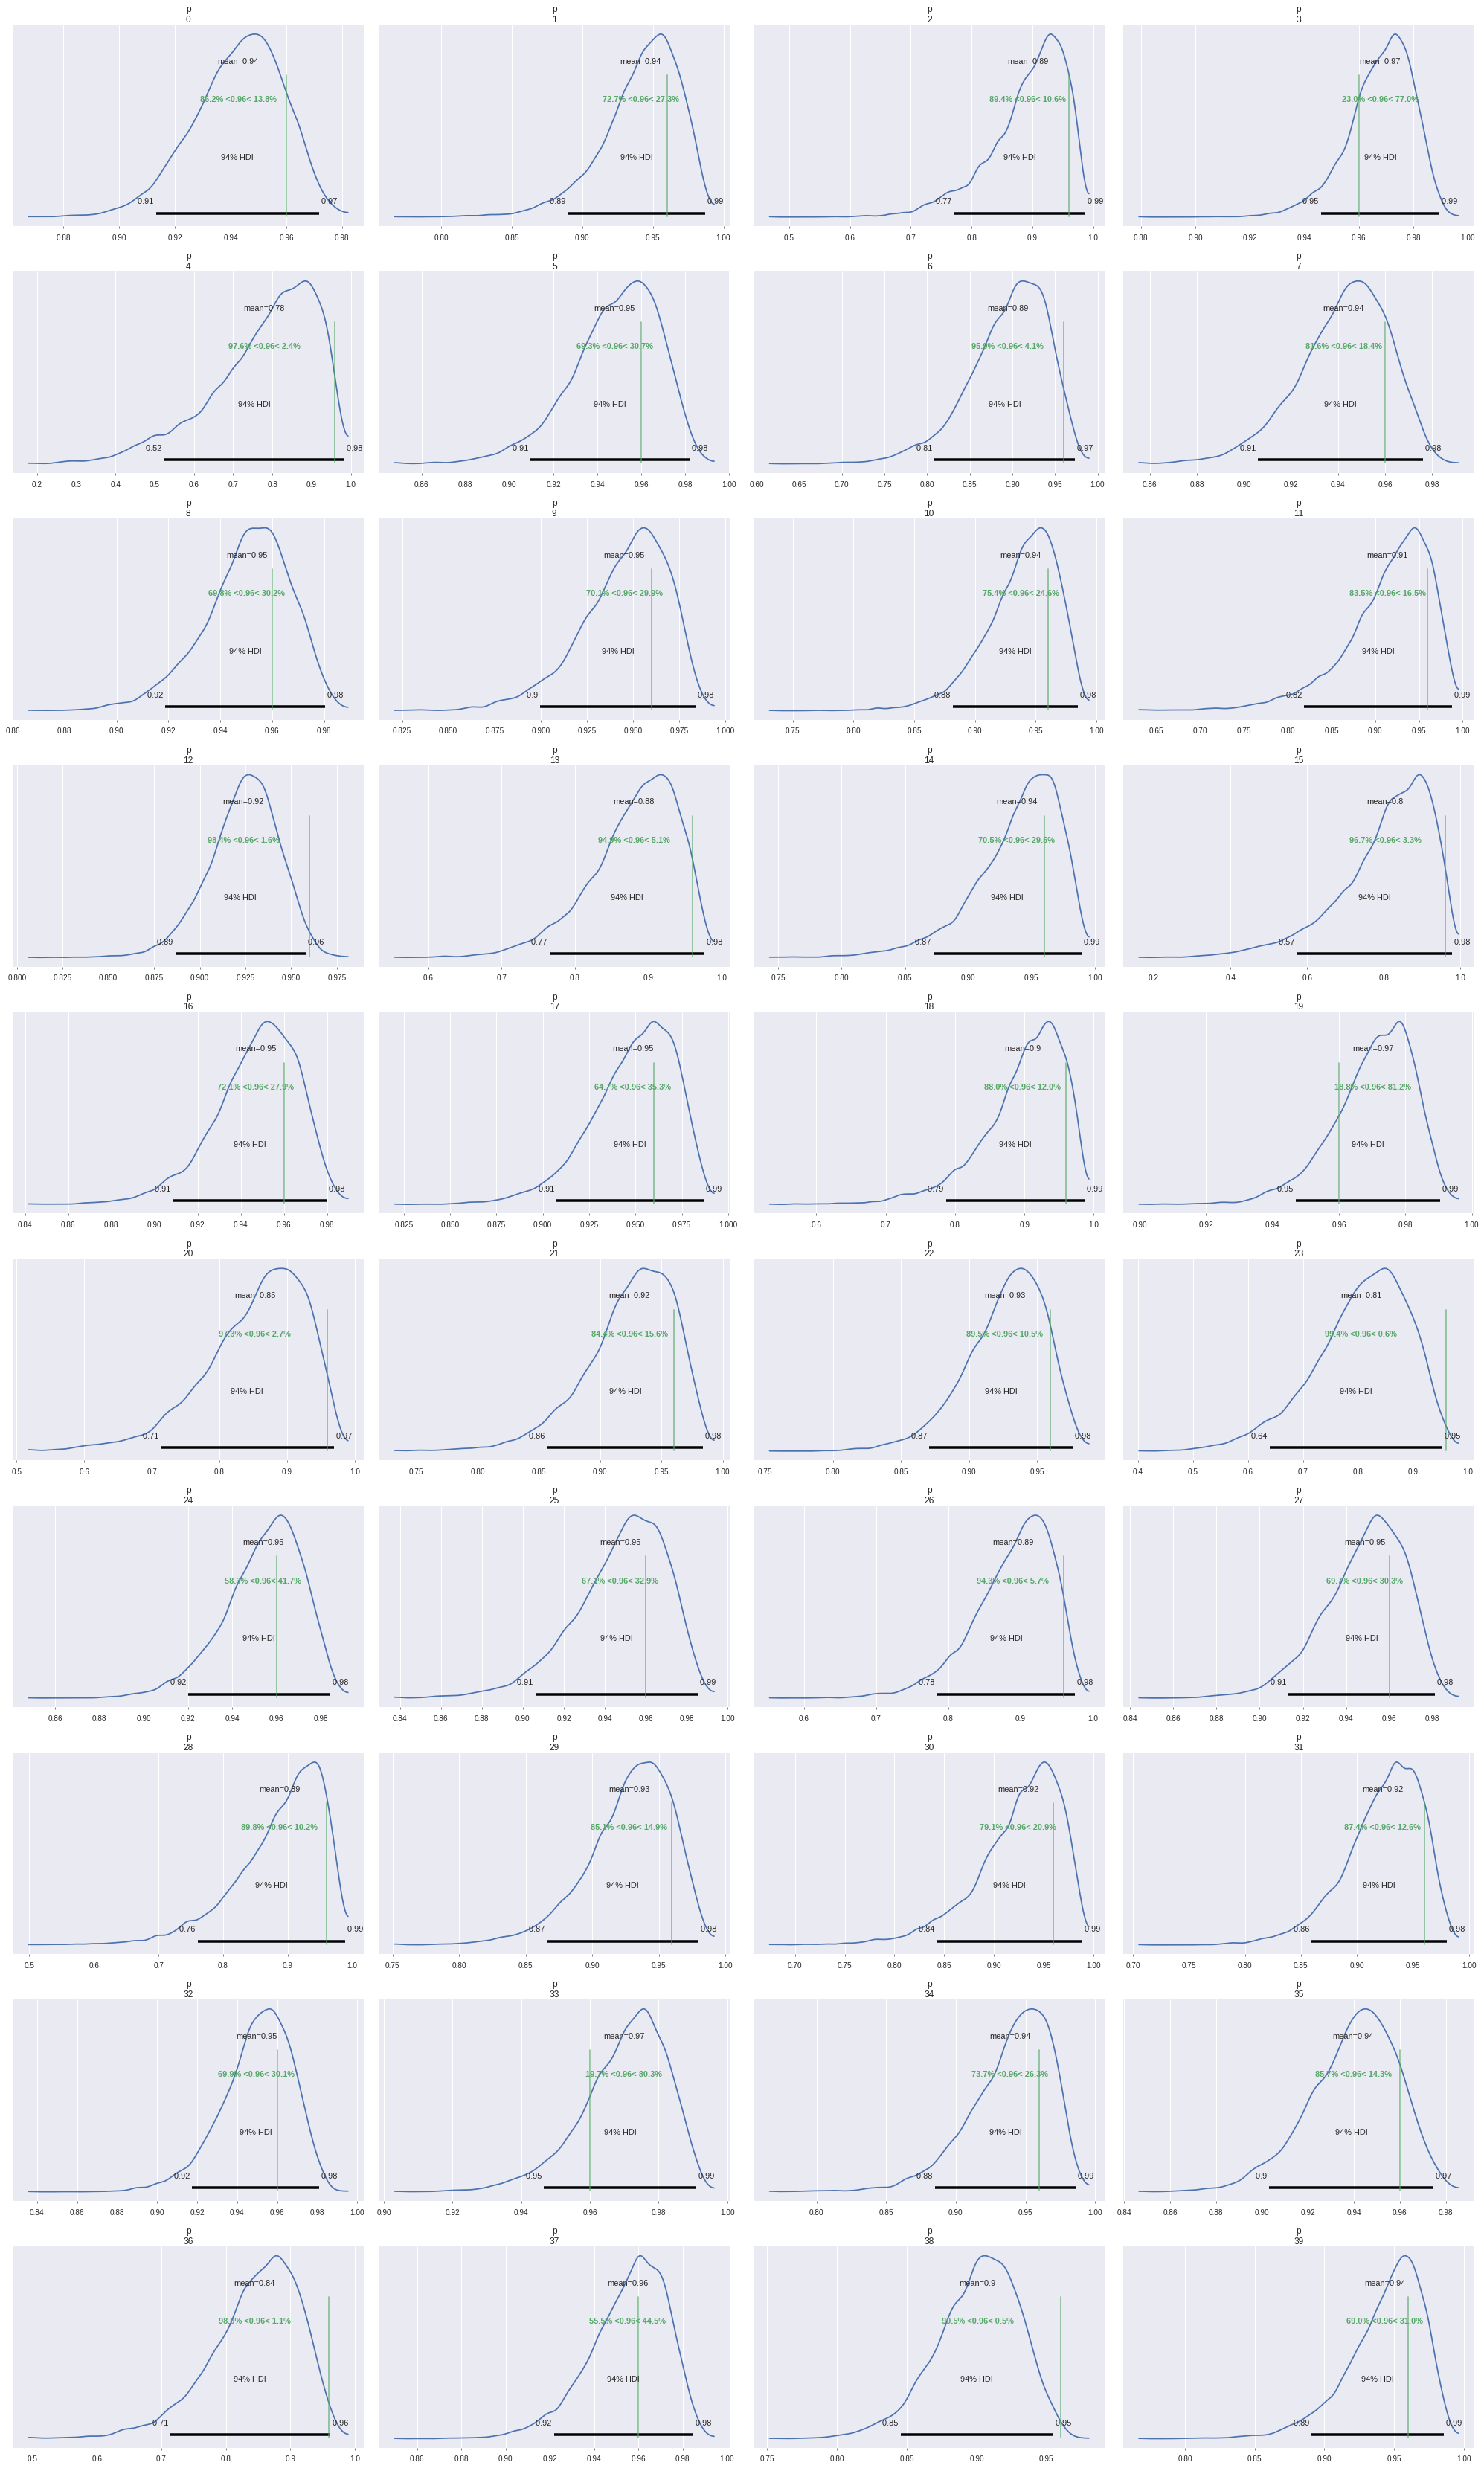

In [415]:
az.plot_posterior(trace_log_norm, var_names=['p'],ref_val = .96);

In [416]:
means_col = []
for i in range(51):
    means_col.append(trace_log_norm.posterior['p'][0,:,i].mean())


In [417]:
np.array(means_col).min()

0.7774434648211763

## Logit with partial pooling
We now assume that the log-odds-ratio of $p_k$ is normal distributed as $\eta_k $. First we partially pool the referees in our three experience chategories. This model can then be written as to 
$$
p_k = \text{sigmoid}(\eta_k)=\frac{1}{1+e^{-\eta_k}}\quad \text{with}\quad\eta_k\sim N(\mu_{j(k)},\sigma_{j(k)}), 
$$

\begin{align*}
\log\Big(\frac{p_k}{1-p_k}\Big)&= N(\mu_{k},\sigma_{k}) + N(\mu_{j(k)},\sigma_{j(k)})=N\Big(\mu_{k} + \mu_{j(k)},\sigma_{k}+\sigma_{j(k)}\Big)  
\end{align*}

where $j(k)\in\{0,1,2\}$ according to the experience of the referee $k$ (0 for Junior, 1 for Mid and 2 for Senior).

In [418]:
import theano.tensor as tt
with pm.Model() as log_norm_hier_ki:
    eta_exp = pm.Normal('eta_exp', mu= 2.5, sigma=.01 ,shape=3)
    eta_p = pm.Normal('eta_p',mu= 2.5, sigma=.01 , shape=len(idx_al_be))
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta_exp[idx_al_be]+eta_p)) 
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)
'''mu_exp = pm.Normal('mu_exp', mu= 1.5, sigma=.01 ,shape=3)
    sig_exp = pm.Uniform('sig_exp',0,.02, shape=3)
    mu_p = pm.Normal('mu_p', mu= 1.5, sigma=.01 , shape=len(idx_al_be))
    sig_p = pm.Uniform('sig_p', 0, .02, shape=len(idx_al_be))
    eta = pm.Normal('eta', mu=mu_p+ mu_exp[idx_al_be],sigma=sig_p+ sig_exp[idx_al_be],shape=len(idx_al_be))
'''

"mu_exp = pm.Normal('mu_exp', mu= 1.5, sigma=.01 ,shape=3)\n    sig_exp = pm.Uniform('sig_exp',0,.02, shape=3)\n    mu_p = pm.Normal('mu_p', mu= 1.5, sigma=.01 , shape=len(idx_al_be))\n    sig_p = pm.Uniform('sig_p', 0, .02, shape=len(idx_al_be))\n    eta = pm.Normal('eta', mu=mu_p+ mu_exp[idx_al_be],sigma=sig_p+ sig_exp[idx_al_be],shape=len(idx_al_be))\n"

In [419]:
trace_log_norm_hier_ki = sample(log_norm_hier_ki, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_p, eta_exp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


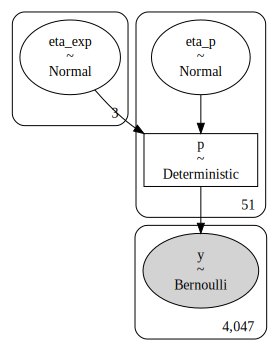

In [420]:
pm.model_to_graphviz(log_norm_hier_ki)

array([[<AxesSubplot:title={'center':'eta_exp'}>,
        <AxesSubplot:title={'center':'eta_exp'}>],
       [<AxesSubplot:title={'center':'eta_p'}>,
        <AxesSubplot:title={'center':'eta_p'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

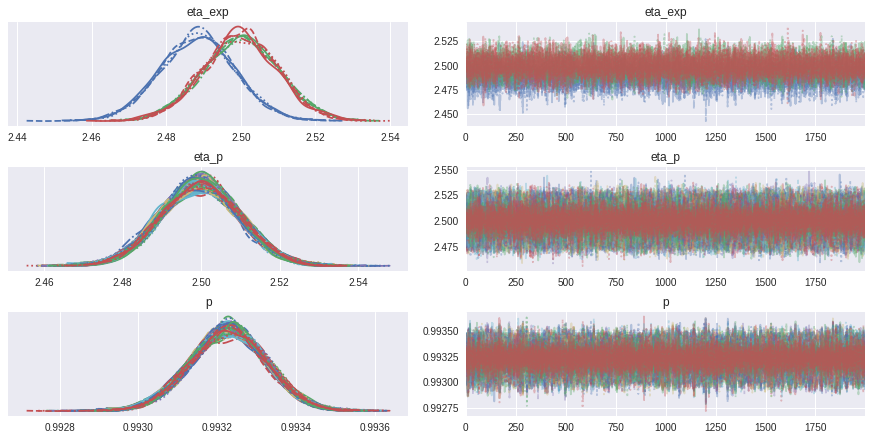

In [421]:
az.plot_trace(trace_log_norm_hier_ki)

$$
Logit(p_k)= N_k + b_1x_k
$$

In [422]:
ref_years = []
for id in idx_al_be:
    ref_years.append(df_ref_c.loc[df_ref_c.ref_1_idx == id].ref_exp.values[0])
np.array(ref_years);

with pm.Model() as log_norm_hier_slop:
    b_0 = pm.Normal('b_0', 0,.001)
    b_1 = pm.Normal('b_1', mu=1, sigma=.1)
    eta_p = pm.Normal('eta_p',mu= 2.5, sigma=.001 , shape=len(idx_al_be)) #mu=1.5 gives nuce res
    p = pm.Deterministic('p',tt.nnet.sigmoid(eta_p +b_0+b_1*ref_years)) 
    y = pm.Bernoulli('y', p[idx], observed=observed_calls)

In [423]:
trace_log_norm_hier_slop = sample(log_norm_hier_slop, n_tune, n_samples, seed, chains)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta_p, b_1, b_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


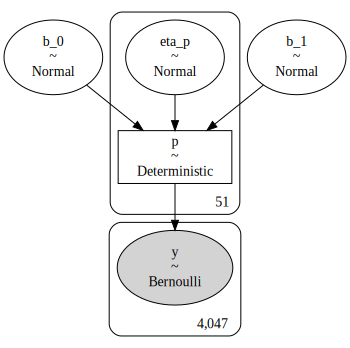

In [424]:
pm.model_to_graphviz(log_norm_hier_slop)

array([[<AxesSubplot:title={'center':'b_0'}>,
        <AxesSubplot:title={'center':'b_0'}>],
       [<AxesSubplot:title={'center':'b_1'}>,
        <AxesSubplot:title={'center':'b_1'}>],
       [<AxesSubplot:title={'center':'eta_p'}>,
        <AxesSubplot:title={'center':'eta_p'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

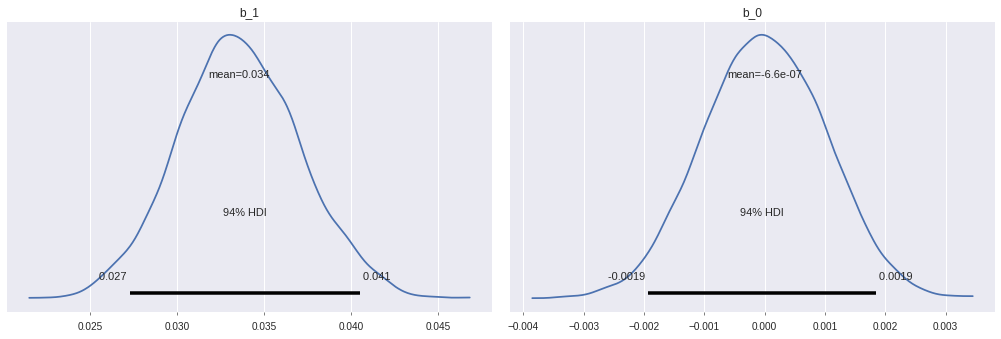

In [425]:
az.plot_posterior(trace_log_norm_hier_slop,var_names=['b_1','b_0'])
az.plot_trace(trace_log_norm_hier_slop)

pm.plot_trace(trace_log_norm_hier_slop)

In [426]:
trace_log_norm_hier_slop.posterior['p'].shape

(4, 2000, 51)

In [427]:
energy_plot(trace_log_norm_hier_slop)

In [428]:
np.log(.96/.04)

3.1780538303479458

In [429]:
import arviz as az

data = az.load_arviz_data('non_centered_eight')

coords = {'school': ['Choate', 'Lawrenceville']}

az.plot_trace(data, var_names=('theta'), filter_vars="like", coords=coords)


array([[<AxesSubplot:title={'center':'theta_t'}>,
        <AxesSubplot:title={'center':'theta_t'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

In [430]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data

In [431]:
trace_log_norm_hier_slop

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [432]:
df.loc[df.period == 'Q3']

Empty DataFrame
Columns: [period, seconds_left, call_type, review_decision, away, home, ref_1, date, score_away, score_home, disadvantaged_team, committing_team, season, ref_exp, ref_exp_cls]
Index: []